In [ ]:
# Load tweet data
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset of tweets
file_path = "/content/drive/MyDrive/CS298/combined.csv"
df = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
columns = df.columns

# print column names
print("The column names are:", columns)

The column names are: Index(['Unnamed: 0', 'tweet id', ' tweet', ' label', 'category'], dtype='object')


In [ ]:

# create a dictionary to map on-topic and off-topic to 1 and 0
mapping = {'On-topic': 1, 'Off-topic': 0, 'on-topic': 1, 'off-topic': 0}

# use the map method to apply the mapping to the column
df[' label'] = df[' label'].map(mapping)

# print the resulting dataframe
print(df)

       Unnamed: 0              tweet id  \
0               0  '348351442404376578'   
1               1  '348167215536803841'   
2               2  '348644655786778624'   
3               3  '350519668815036416'   
4               4  '351446519733432320'   
...           ...                   ...   
69134       69134  '325357142418792448'   
69135       69135  '324425973623816193'   
69136       69136  '324674851572965376'   
69137       69137  '325378699237142528'   
69138       69138  '324513442813861889'   

                                                   tweet   label category  
0      @Jay1972Jay Nope. Mid 80's. It's off Metallica...       0   floods  
1      Nothing like a :16 second downpour to give us ...       0   floods  
2      @NelsonTagoona so glad that you missed the flo...       1   floods  
3      Party hard , suns down , still warm , lovin li...       0   floods  
4      @Exclusionzone if you compare yourself to wate...       0   floods  
...                        

In [ ]:
unique_values = df[' label'].unique()

# print the unique values
print(unique_values)

[0 1]


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.4 MB/s eta 0:00:00


In [ ]:
# Load BERT tokenizer
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Concatenate, Bidirectional, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


In [ ]:
# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Set up input and output shape
max_length = 128
input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")

In [ ]:
# Get BERT embeddings
bert_output = bert_model([input_word_ids, input_mask, segment_ids])[0]

In [ ]:
bert_output.shape

TensorShape([None, 128, 768])

In [ ]:
# Set up bi-LSTM layer
lstm_units = 64
lstm_output = Bidirectional(LSTM(lstm_units, return_sequences=True))(bert_output)

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling1D

# Set up bi-LSTM layer with L2 regularization
lstm_units = 64
lstm_output = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))(bert_output)

# Add dropout layer
dropout_rate = 0.5
dropout_output = Dropout(dropout_rate)(lstm_output)

# Set up CNN layer with L2 regularization
num_filters = 64
kernel_size = 3
conv_output = Conv1D(num_filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(dropout_output)
pool_output = MaxPooling1D(pool_size=2, strides=1, padding='same')(conv_output)

# Concatenate the two inputs
concat_output = Concatenate()([dropout_output, pool_output])
reduced_output = GlobalMaxPooling1D()(concat_output)

In [ ]:
lstm_output.shape

TensorShape([None, 128, 128])

In [ ]:
# Set up CNN layer
num_filters = 64
kernel_size = 3
conv_output = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(lstm_output)
pool_output = MaxPooling1D(pool_size=2, strides=1, padding='same')(conv_output)

In [ ]:
pool_output.shape

TensorShape([None, 128, 64])

In [ ]:
# Concatenate the two inputs
concat_output = Concatenate()([lstm_output, pool_output])

In [ ]:
# Set up dense layer and output layer
dense_units = 128
dropout_rate = 0.5
dense_output = Dense(dense_units, activation='relu')(reduced_output)
dropout_output = Dropout(dropout_rate)(dense_output)
output = Dense(1, activation='sigmoid')(dropout_output)

In [ ]:
# Define model input and output
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output)

In [ ]:
# Compile model
learning_rate = 1e-5
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
# Convert tweets to BERT embeddings
input_ids = []
attention_masks = []
token_type_ids = []

for tweet in df[' tweet']:
  encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'tf'
                   )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])
  token_type_ids.append(encoded_dict['token_type_ids'])

input_ids = np.concatenate(input_ids, axis=0)
attention_masks = np.concatenate(attention_masks, axis=0)
token_type_ids = np.concatenate(token_type_ids, axis=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Train model

batch_size = 32
epochs = 5
X_train_ids, X_test_ids, X_train_masks, X_test_masks, X_train_segments, X_test_segments, y_train, y_test = train_test_split(input_ids, attention_masks, token_type_ids, df[' label'], test_size=0.2, random_state=42)


In [ ]:
# Train model
history = model.fit(
    x=[X_train_ids, X_train_masks, X_train_segments],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2)

Epoch 1/5


1383/1383 [==============================] - 1363s 941ms/step - loss: 7.4401 - accuracy: 0.8843 - val_loss: 6.1505 - val_accuracy: 0.8998
Epoch 2/5
1383/1383 [==============================] - 1299s 940ms/step - loss: 5.0215 - accuracy: 0.9141 - val_loss: 4.0965 - val_accuracy: 0.9127
Epoch 3/5
1383/1383 [==============================] - 1298s 939ms/step - loss: 3.2900 - accuracy: 0.9288 - val_loss: 2.6832 - val_accuracy: 0.9167
Epoch 4/5
1383/1383 [==============================] - 1298s 939ms/step - loss: 2.0971 - accuracy: 0.9434 - val_loss: 1.7455 - val_accuracy: 0.9061
Epoch 5/5
1383/1383 [==============================] - 1301s 940ms/step - loss: 1.3091 - accuracy: 0.9550 - val_loss: 1.1529 - val_accuracy: 0.9054


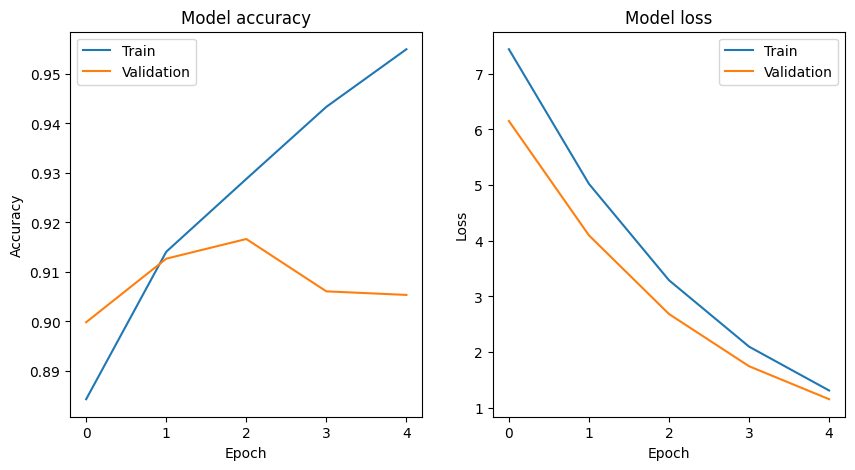

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
#test model

y_pred = model.predict([X_test_ids, X_test_masks, X_test_segments])
y_pred = np.round(y_pred.squeeze()).astype(int)

433/433 [==============================] - 130s 289ms/step


In [ ]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

y_test shape: (13828,)
y_pred shape: (13828,)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9032
Recall: 0.9356
Precision: 0.8886
F1 Score: 0.9115
